## Project 1


### Import Dependencies

In [47]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
import datetime
import math
import random
import holoviews as hv
import hvplot.pandas

import panel as pn
from yahoo_fin import stock_info as si
from yahoo_earnings_calendar import YahooEarningsCalendar
from MCForecastTools import MCSimulation

In [ ]:
# Load .env enviroment variables
initial_investment = 10000

from dotenv import load_dotenv
load_dotenv()

In [ ]:
### Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


In [ ]:
#Ask User for intitial investment
investment_slider = pn.widgets.FloatSlider(name='Initial Investment', start=1000, end=100000, step=100, value=10000)

investment_slider

### Dynamically Pull Stocks Based on Earnings Date

In [25]:
#Store initial investment
initial_investment = investment_slider.value

In [6]:
#Ask the user for number of days to look at future earnings
day_slider = pn.widgets.FloatSlider(name='Please select the number of days to look at for earnings', start=1, end=25, step=1, value=2)

day_slider

FloatSlider(end=25, name='Please select t..., start=1, step=1, value=2, value_throttled=2)

In [ ]:
#Store Selected days
furture_days = day_slider.value
furture_days

In [27]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 1) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = furture_days) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')
yec = YahooEarningsCalendar()
stock_earnings = yec.earnings_between(date_from, date_to)


In [28]:
stock_list = [{'ticker': ticker['ticker'], 'epsestimate': ticker['epsestimate']} for ticker in stock_earnings if ticker['epsestimate']]
tickers = []
for i in stock_list:
    if i["ticker"] not in tickers:
        tickers.append((i["ticker"]))
        
print(tickers)

['MTSC', 'NDSN', 'ABM', 'CNTG', 'LEN', 'TTC', 'REVG', 'MLHR', 'ACN', 'AIR', 'NAV', 'CAMP', 'SCHL', 'FDX', 'SAFM', 'GIS', 'OTLK', 'JBL', 'WOR']


In [29]:
# Set timeframe to '1D'
timeframe = "1D"

#Set timeframe for last 2 years
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp(next_day, tz="America/New_York").isoformat()

#Get ticker data
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.head()

ABM                                      ACN  \
                            open     high    low  close    volume    open   
time                                                                        
2018-05-01 00:00:00-04:00  31.04  31.0900  30.26  30.64  658848.0  151.09   
2018-05-02 00:00:00-04:00  30.63  30.6700  30.39  30.48  670396.0  151.72   
2018-05-03 00:00:00-04:00  30.46  30.6100  30.16  30.22  505683.0  150.30   
2018-05-04 00:00:00-04:00  30.16  30.4400  29.87  30.32  645674.0  150.71   
2018-05-07 00:00:00-04:00  30.37  30.4336  30.09  30.11  625649.0  152.95   

                                                                 ...    TTC  \
                              high       low   close     volume  ...   open   
time                                                             ...          
2018-05-01 00:00:00-04:00  151.950  150.1200  151.88   821409.0  ...  58.34   
2018-05-02 00:00:00-04:00  152.090  150.4100  150.69   891638.0  ...  58.23   
2018-05-03 00:00:00-04:00  152.040  149.1400  151.68  1181445.0  ...  58.09   
2018-05-04 00:00:00-04:00  153.955  150.3500  153.44  1094740.0  ...  57.73   
2018-05-07 00:00:00-04:00  153.080  151.8408  152.32  1437543.0  ...  59.07   

                                                            WOR                \
                            high    low  close    volume   open   high    low   
time                                                                            
2018-05-01 00:00:00-04:00  58.60  56.83  58.22  443008.0  44.23  44.56  43.35   
2018-05-02 00:00:00-04:00  58.88  57.82  58.16  340310.0  44.59  44.82  43.97   
2018-05-03 00:00:00-04:00  58.62  57.24  58.18  323878.0  44.13  44.67  43.31   
2018-05-04 00:00:00-04:00  59.20  57.64  58.80  280470.0  43.53  44.69  43.24   
2018-05-07 00:00:00-04:00  59.93  59.07  59.32  485356.0  44.54  45.22  44.30   

                                            
                           close    volume  
time                                        
2018-05-01 00:00:00-04:00  44.37  214155.0  
2018-05-02 00:00:00-04:00  44.07  153262.0  
2018-05-03 00:00:00-04:00  43.75  179879.0  
2018-05-04 00:00:00-04:00  44.36  197542.0  
2018-05-07 00:00:00-04:00  45.19  187717.0  

[5 rows x 95 columns]

In [30]:
#Cleanup Pandas Data for Close Prices only
df_closing_prices = pd.DataFrame()

for ticker in tickers: 
    df_closing_prices[ticker] = df_ticker[ticker]["close"]

In [31]:
#Generate Closing Price Graph
df_closing_prices.index = df_closing_prices.index.date

daily_close = df_closing_prices.hvplot.line()
daily_close

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [32]:
#Generate Daily Returns Graph 
df_daily_returns = df_closing_prices.pct_change().dropna()

daily_returns = df_daily_returns.hvplot.line()
daily_returns

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [33]:
### Dynamically Generate Weights 

In [95]:
total = 1
weight_list = []
#portfolios = 5
#for num in range(len(portfolios)):
for i in range(len(tickers)):
    if i == (len(tickers)-1):
        weight_list.append(round(total,2))
    elif len(tickers) > 1 and len(tickers) <= 5:
        weight = (round(random.uniform(0,total),2))
        weight_list.append(round(weight,2))
        total -= weight
    elif len(tickers) > 5:
        weight = (round(random.uniform(0.1,total)/3,8))
        weight_list.append(round(weight,2))
        total -= weight        
    else:
        weight_list.append(1.0)
print(weight_list)

[0.33, 0.04, 0.13, 0.15, 0.06, 0.08, 0.06, 0.04, 0.03, 0.03, 0.03, 0.01, 0.02, 0.0, 0.03, -0.01, 0.0, -0.01, -0.03]


In [98]:
df_weights = pd.DataFrame(index=["Weights"])

for ticker in tickers: 
    df_weights[ticker] = weight_list[tickers.index(ticker)]
df_weights.head()

,MTSC,NDSN,ABM,CNTG,LEN,TTC,REVG,MLHR,ACN,AIR,NAV,CAMP,SCHL,FDX,SAFM,GIS,OTLK,JBL,WOR
Weights,0.33,0.04,0.13,0.15,0.06,0.08,0.06,0.04,0.03,0.03,0.03,0.01,0.02,0.0,0.03,-0.01,0.0,-0.01,-0.03


In [99]:
df_weights = df_weights.hvplot.heatmap()
df_weights

:HeatMap   [columns,index]   (value)

### The MCForecastTools Library at a Glance

### Simulate five year portfolio growth using Monte Carlo simulation

In [37]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_ticker,
    weights = weight_list,
    num_simulation = 500,
    num_trading_days = 252*5
)

In [38]:
# Printing the simulation input data
MC_fiveyear.portfolio_data.head()

ABM                                   \
                            open     high    low  close    volume   
time                                                                
2018-05-01 00:00:00-04:00  31.04  31.0900  30.26  30.64  658848.0   
2018-05-02 00:00:00-04:00  30.63  30.6700  30.39  30.48  670396.0   
2018-05-03 00:00:00-04:00  30.46  30.6100  30.16  30.22  505683.0   
2018-05-04 00:00:00-04:00  30.16  30.4400  29.87  30.32  645674.0   
2018-05-07 00:00:00-04:00  30.37  30.4336  30.09  30.11  625649.0   

                                           ACN                             \
                          daily_return    open     high       low   close   
time                                                                        
2018-05-01 00:00:00-04:00          NaN  151.09  151.950  150.1200  151.88   
2018-05-02 00:00:00-04:00    -0.005222  151.72  152.090  150.4100  150.69   
2018-05-03 00:00:00-04:00    -0.008530  150.30  152.040  149.1400  151.68   
2018-05-04 00:00:00-04:00     0.003309  150.71  153.955  150.3500  153.44   
2018-05-07 00:00:00-04:00    -0.006926  152.95  153.080  151.8408  152.32   

                           ...    TTC                                  WOR  \
                           ...    low  close    volume daily_return   open   
time                       ...                                               
2018-05-01 00:00:00-04:00  ...  56.83  58.22  443008.0          NaN  44.23   
2018-05-02 00:00:00-04:00  ...  57.82  58.16  340310.0    -0.001031  44.59   
2018-05-03 00:00:00-04:00  ...  57.24  58.18  323878.0     0.000344  44.13   
2018-05-04 00:00:00-04:00  ...  57.64  58.80  280470.0     0.010657  43.53   
2018-05-07 00:00:00-04:00  ...  59.07  59.32  485356.0     0.008844  44.54   

                                                                       
                            high    low  close    volume daily_return  
time                                                                   
2018-05-01 00:00:00-04:00  44.56  43.35  44.37  214155.0          NaN  
2018-05-02 00:00:00-04:00  44.82  43.97  44.07  153262.0    -0.006761  
2018-05-03 00:00:00-04:00  44.67  43.31  43.75  179879.0    -0.007261  
2018-05-04 00:00:00-04:00  44.69  43.24  44.36  197542.0     0.013943  
2018-05-07 00:00:00-04:00  45.22  44.30  45.19  187717.0     0.018711  

[5 rows x 114 columns]

In [39]:
# Running a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998330,0.981941,0.992537,0.995145,1.005795,0.989835,1.000354,0.999755,1.009055,1.001682,...,1.004287,0.977497,0.996098,0.985412,0.997225,1.009996,1.011829,1.017973,1.001399,0.990102
2,0.986639,0.958654,0.974252,0.997710,1.025820,0.994887,1.013145,1.012176,1.016886,0.990403,...,1.010268,0.971795,1.020394,1.008332,1.022477,0.991746,1.030492,1.034757,0.979777,1.015486
3,0.978355,0.985542,0.977947,1.017370,1.032226,0.991778,1.021197,1.001670,1.010783,0.992452,...,1.006225,0.959890,0.988870,1.010600,1.028976,0.988566,1.028372,1.033358,0.991847,1.007360
4,0.974121,0.977766,1.014555,1.044588,1.019740,0.997376,1.016904,0.964682,1.022652,1.007744,...,0.997191,0.964160,0.989499,1.016393,1.034089,0.987917,1.056030,1.013066,1.016165,1.004266
5,0.981029,0.957232,1.029160,1.069140,1.040399,0.988889,1.000407,0.956936,1.005357,1.008002,...,0.994693,0.985923,0.998472,1.026295,1.052777,0.977002,1.053853,1.001991,1.013065,1.037650
6,0.984096,0.976236,1.033574,1.105375,1.055951,0.988362,1.008092,0.978863,0.983410,1.017540,...,1.004781,1.004102,0.975115,1.007141,1.041330,0.956573,1.063294,0.967735,1.026454,1.039904
7,0.976568,0.967307,1.025080,1.079859,1.041901,0.980940,1.020761,0.968370,0.970465,1.017007,...,0.999409,1.016423,0.960080,1.000142,1.041927,0.960300,1.080049,0.965386,1.057389,1.040822
8,0.967254,0.986882,1.033927,1.069239,1.047909,0.993815,1.021764,0.951608,0.975182,1.026500,...,0.996146,1.021098,0.951724,0.997890,1.026697,0.947691,1.089364,0.981278,1.063458,1.038612
9,0.970224,0.983387,0.996359,1.074938,1.031741,1.006492,1.015633,0.944056,0.959311,1.012482,...,0.991590,0.963208,0.943566,0.992523,1.055820,0.943306,1.079464,0.988852,1.056628,1.038919


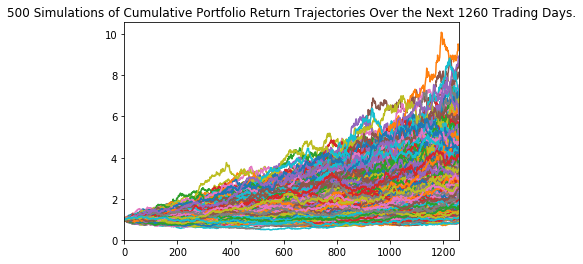

In [40]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

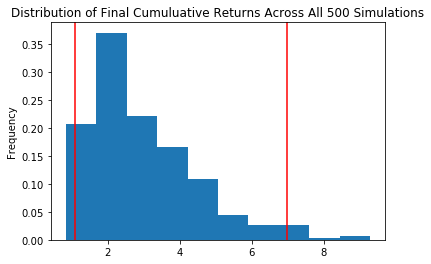

In [41]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [42]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              2.963622
std               1.476268
min               0.833814
25%               1.889129
50%               2.565992
75%               3.732524
max               9.295385
95% CI Lower      1.085273
95% CI Upper      6.994813
Name: 1260, dtype: float64


In [43]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in Coca-Cola and Microsoft stocks
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10000 in the portfolio over the next 5 years will end within in the range of $10852.73 and $69948.13


In [44]:
portfolio = {}
for ticker in tickers:
    stock_weight = weight_list[tickers.index(ticker)] * initial_investment
    current_stock_price = round(si.get_live_price(ticker),2)
    portfolio_weight = stock_weight//current_stock_price
    portfolio[ticker] = math.floor(portfolio_weight)

for key in portfolio.keys():
    mystring = f"Buy {key}: {portfolio[key]} shares"
    print(mystring)

Buy MTSC: 8 shares
Buy NDSN: 5 shares
Buy ABM: 45 shares
Buy CNTG: 178 shares
Buy LEN: 8 shares
Buy TTC: 12 shares
Buy REVG: 42 shares
Buy MLHR: 13 shares
Buy ACN: 1 shares
Buy AIR: 14 shares
Buy NAV: 9 shares
Buy CAMP: 28 shares
Buy SCHL: 7 shares
Buy FDX: 0 shares
Buy SAFM: 0 shares
Buy GIS: 1 shares
Buy OTLK: 75 shares
Buy JBL: 7 shares
Buy WOR: -10 shares
